In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
flowlines = gpd.read_file('../data/flowlines_all.geojson')

cat = ['StreamOrde', 'StartFlag', 'TerminalFl', 'huc4']
num = ['AreaSqKM', 'LENGTHKM', 'ArbolateSu', 'SLOPE', 'MAXELEVSMO', 
       'MINELEVSMO', 'QA_MA', 'VA_MA', 'QA_01', 'VA_01']

flowlines.set_index('COMID', inplace=True)
flowlines = flowlines[cat + num]
flowlines

,StreamOrde,StartFlag,TerminalFl,huc4,AreaSqKM,LENGTHKM,ArbolateSu,SLOPE,MAXELEVSMO,MINELEVSMO,QA_MA,VA_MA,QA_01,VA_01
COMID,,,,,,,,,,,,,,
19772077,2,0,0,1806,0.1269,0.475,565.812,0.002926,9369.0,9230.0,0.096,0.63744,0.216,0.81453
19772079,4,0,0,1806,0.2376,1.036,557.847,0.001364,9351.0,9230.0,0.004,0.45006,0.009,0.52630
19772139,1,1,0,1806,8.4627,7.276,7.276,0.008793,16520.0,10255.0,0.153,0.74385,0.359,0.99330
19772159,2,0,0,1806,0.6291,1.606,11.969,0.002696,10255.0,9822.0,0.234,0.70639,0.541,0.92948
19772169,3,0,0,1806,1.6839,1.354,38.094,0.001411,9822.0,9631.0,0.725,0.77303,1.728,1.04530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236560,1,0,0,1801,0.2583,0.575,1.380,0.300452,169131.0,151855.0,1.199,0.94602,1.805,1.10072
8235184,1,0,0,1801,0.1782,0.616,0.805,0.330763,189506.0,169131.0,0.862,0.90435,1.176,1.01122
8235174,1,0,0,1801,0.9630,1.233,2.613,0.245109,151855.0,121633.0,2.412,1.04157,4.188,1.29116


## Data Cleaning

In [3]:
flowlines = flowlines.replace(to_replace=[-9999.00, -9998.00], value=np.nan)

for col in ['QA_MA', 'VA_MA', 'QA_01', 'VA_01']:
    flowlines[col] = flowlines[col].replace(to_replace=0.00, value=np.nan)

for col in ['AreaSqKM', 'LENGTHKM', 'ArbolateSu','MAXELEVSMO', 'MINELEVSMO']:
    flowlines[col] = flowlines[col].replace(to_replace=0.00, value=np.nan)

# if slope is greater than 1, set to NaN
flowlines['SLOPE'].where(flowlines['SLOPE'] < 1.00, np.nan, inplace=True)

# Stream order of 0 is 'headwater' ? but fails this test, so not sure
#test = flowlines[flowlines['StreamOrde'] == 0]
# test['StartFlag'].value_counts()
# perhaps not connected to the network? 

# convert units
flowlines['MAXELEVSMO'] = flowlines['MAXELEVSMO'] / 100 # cm to m
flowlines['MINELEVSMO'] = flowlines['MINELEVSMO'] / 100 # cm to m

# log transform to AreaSqKM, ArbolateSu, QA_MA
flowlines['AreaSqKM'] = np.log(flowlines['AreaSqKM'])
flowlines['ArbolateSu'] = np.log(flowlines['ArbolateSu'])
flowlines['QA_MA'] = np.log(flowlines['QA_MA'])


# add simple_elevation column
flowlines['simple_elevation'] = (flowlines['MAXELEVSMO'] + flowlines['MINELEVSMO']) / 2

# drop not needed columns
flowlines = flowlines[["StreamOrde", "LENGTHKM", "AreaSqKM", "ArbolateSu", "SLOPE",  "simple_elevation", "QA_MA", "VA_MA", "huc4"]]

# rename columns
columns = {
    "StreamOrde": "stream_order",
    "LENGTHKM": "length_km",
    "AreaSqKM": "log_area_sq_km",
    "ArbolateSu": "log_upstream_length_km",
    "SLOPE": "slope",
    "simple_elevation": "elevation_m",
    "QA_MA": "log_mean_q_cfs",
    "VA_MA": "mean_v_fs",
    "huc4": "subregion"
}

num = ['length_km', 'log_area_sq_km', 'log_upstream_length_km', 'slope', 'elevation_m',  'log_mean_q_cfs', 'mean_v_fs']
cat = ['stream_order', 'subregion']
flowlines = flowlines.rename(columns=columns)
flowlines = flowlines.drop_duplicates()
flowlines


,stream_order,length_km,log_area_sq_km,log_upstream_length_km,slope,elevation_m,log_mean_q_cfs,mean_v_fs,subregion
COMID,,,,,,,,,
19772077,2,0.475,-2.064356,6.338262,0.002926,92.995,-2.343407,0.63744,1806
19772079,4,1.036,-1.437167,6.324085,0.001364,92.905,-5.521461,0.45006,1806
19772139,1,7.276,2.135668,1.984581,0.008793,133.875,-1.877317,0.74385,1806
19772159,2,1.606,-0.463465,2.482320,0.002696,100.385,-1.452434,0.70639,1806
19772169,3,1.354,0.521113,3.640057,0.001411,97.265,-0.321584,0.77303,1806
...,...,...,...,...,...,...,...,...,...
8236560,1,0.575,-1.353634,0.322083,0.300452,1604.930,0.181488,0.94602,1801
8235184,1,0.616,-1.724849,-0.216913,0.330763,1793.185,-0.148500,0.90435,1801
8235174,1,1.233,-0.037702,0.960499,0.245109,1367.440,0.880456,1.04157,1801


## Data Exploration

### % Missing Values from Each Column

In [ ]:
(flowlines.isna().sum() / len(flowlines) * 100).round(2)

## SubRegions Map

In [ ]:
subregions = gpd.read_file('../data/subregions.geojson')
subregions

In [ ]:
subregions.plot(figsize=(15,15))
subregions['coords'] = subregions['geometry'].apply(lambda x: x.representative_point().coords[:])
subregions['coords'] = [coords[0] for coords in subregions['coords']]
subregions['label'] = subregions['huc4'] + '\n' + subregions['name']
for idx, row in subregions.iterrows():
    count = (flowlines['subregion'] == row['huc4']).sum()
    label = row['label'] + '\n' + str(count)
    plt.annotate(text=label, xy=row['coords'], horizontalalignment='center')

### Categorical Variables

In [ ]:
# Number of streams per subregion and stream_order
fig, axs = plt.subplots(1,2, figsize=(12, 6))
for axis,col in zip(axs, cat):
    sns.countplot(x=col, data=flowlines, ax=axis)

In [ ]:
# stream order by region
cond_plot = sns.FacetGrid(flowlines, col='subregion', col_wrap=3)
cond_plot.map(sns.countplot, 'stream_order', order=range(0, 8))

## Numerical Variables

In [ ]:
flowlines[num].describe().round(2)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=False, sharex=False)
for ax, col in zip(axs.flatten(), num):
    sns.histplot(flowlines[col], ax=ax, bins=30)
    ax.set_ylabel('')

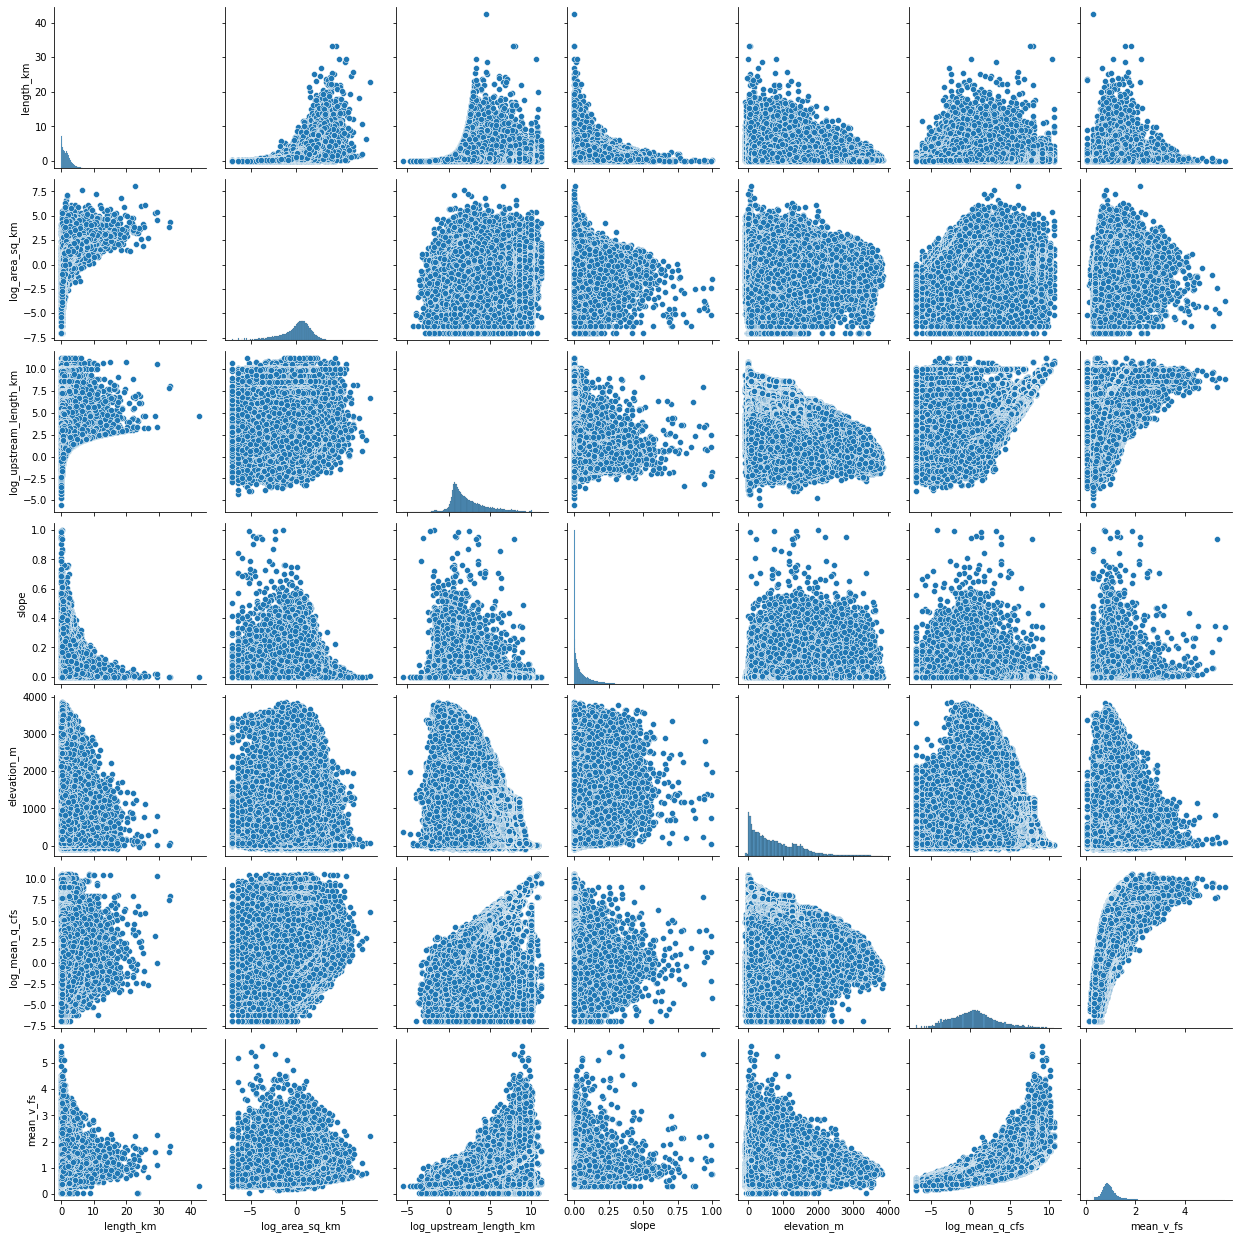

In [4]:
sns.pairplot(flowlines[num].drop_duplicates(), dropna=True)

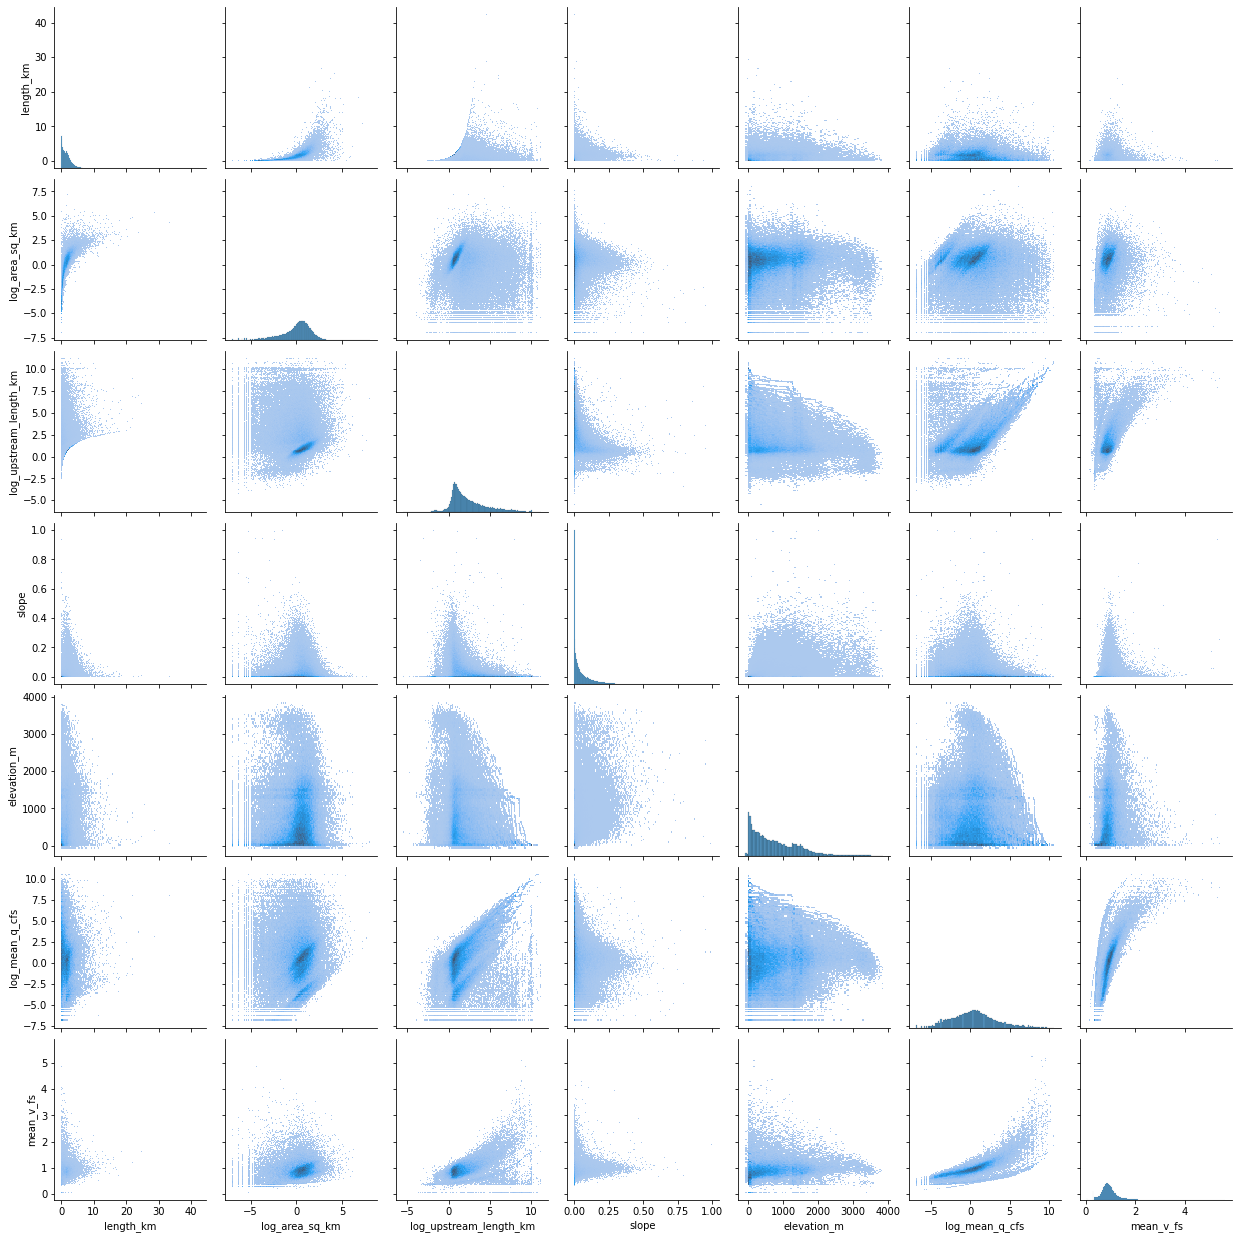

In [6]:
sns.pairplot(flowlines[num].drop_duplicates(), dropna=True, kind='hist')

Stream order, Region ~ Numeric Variables

In [ ]:
# visualize relationship between all variables and stream order
fig, axs = plt.subplots(3, 3, figsize=(20, 10), sharey=False)
for ax, col in zip(axs.flatten(), num):
    sns.boxplot(x='subregion', y=col, data=flowlines, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
# visualize relationship between all variables and stream order
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for ax, col in zip(axs.flatten(), num):
    sns.boxplot(x='stream_order', y=col, data=flowlines, ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')